In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../idena_v1.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h,idena_unscaled,idena_monthly,scale,idena
Date,,,,,,,,,,,,,,,,
2020-08-11,2020-08-11,0.125496,0.137770,0.124239,0.130634,0.130634,40783,1817.0,0.273,0.000,298,6.666667,0,37.0,0.37,0.00
2020-08-12,2020-08-12,0.130674,0.162275,0.128384,0.138122,0.138122,65517,1829.0,0.182,0.091,300,6.750000,0,37.0,0.37,0.00
2020-08-13,2020-08-13,0.138128,0.138128,0.118348,0.127606,0.127606,41988,2149.0,0.083,0.167,302,6.615385,0,37.0,0.37,0.00
2020-08-14,2020-08-14,0.127084,0.201024,0.121670,0.201024,0.201024,104705,2208.0,0.000,0.000,304,7.083333,34,37.0,0.37,12.58
2020-08-15,2020-08-15,0.201097,0.202423,0.138915,0.162744,0.162744,50419,2267.0,0.100,0.000,307,5.636364,0,37.0,0.37,0.00


<AxesSubplot:xlabel='Date'>

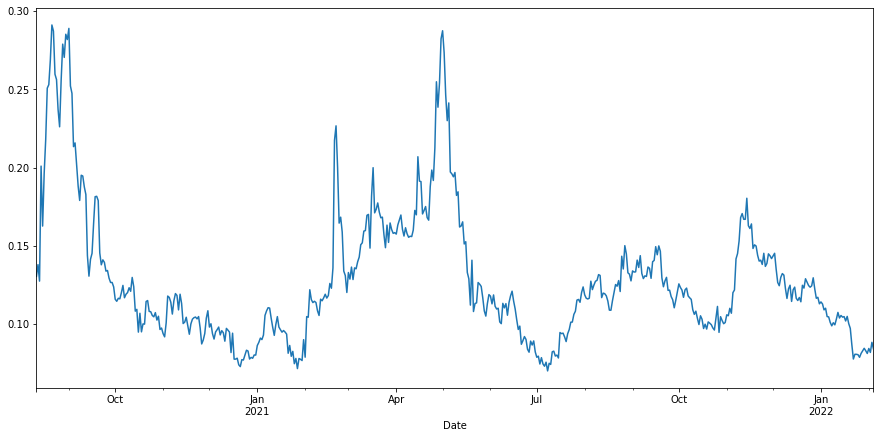

In [3]:
df = df.resample('D').ffill()
df.Close.plot(figsize=(15, 7))


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,reddit_subscribers,reddit_accounts_active_48h,idena_unscaled,idena_monthly,scale,idena
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,0.128692,0.137397,0.120630,0.128571,0.128571,106102.254144,4902.164825,0.102276,0.311459,601.655617,10.590905,29.587477,40.119705,0.401197,12.497403
std,0.042882,0.048555,0.039002,0.042855,0.042855,97285.658149,2042.128206,0.118870,0.451204,200.510164,7.184012,29.176571,15.993265,0.159933,14.297313
min,0.070355,0.075546,0.061175,0.070285,0.070285,904.000000,1817.000000,0.000000,0.000000,298.000000,4.500000,0.000000,0.000000,0.000000,0.000000
25%,0.101087,0.105671,0.094967,0.100634,0.100634,42497.500000,3301.000000,0.000000,0.000000,387.000000,7.416667,0.000000,29.000000,0.290000,0.000000
50%,0.118062,0.123798,0.113222,0.117744,0.117744,68854.000000,4034.000000,0.083000,0.167000,585.000000,8.615385,25.000000,39.000000,0.390000,9.520000
75%,0.143867,0.151944,0.136225,0.143835,0.143835,143341.000000,5975.500000,0.167000,0.417000,786.000000,10.769231,46.000000,51.000000,0.510000,18.950000
max,0.295889,0.316882,0.277482,0.291120,0.291120,536465.000000,9593.000000,0.636000,3.750000,926.000000,68.076923,100.000000,100.000000,1.000000,100.000000


In [5]:
from python_scripts.sarima_helper import create_lagged_value_columns

df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Open", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h", 'idena_unscaled',
                'idena_monthly', 'scale', 'idena']
windows = [3,7,14,21,30,60]
df = create_lagged_value_columns(lag_features, windows, df)

In [6]:
testNum = round(df.shape[0] * 0.3)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


In [7]:
df.fillna(df.mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 543 entries, 2020-08-11 to 2022-02-04
Data columns (total 94 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    543 non-null    datetime64[ns]
 1   Open                                    543 non-null    float64       
 2   High                                    543 non-null    float64       
 3   Low                                     543 non-null    float64       
 4   Close                                   543 non-null    float64       
 5   Adj Close                               543 non-null    float64       
 6   Volume                                  543 non-null    int64         
 7   twitter_followers                       543 non-null    float64       
 8   reddit_average_posts_48h                543 non-null    float64       
 9   reddit_average_comments_48h        

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 543 entries, 2020-08-11 to 2022-02-04
Data columns (total 94 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    543 non-null    datetime64[ns]
 1   Open                                    543 non-null    float64       
 2   High                                    543 non-null    float64       
 3   Low                                     543 non-null    float64       
 4   Close                                   543 non-null    float64       
 5   Adj Close                               543 non-null    float64       
 6   Volume                                  543 non-null    int64         
 7   twitter_followers                       543 non-null    float64       
 8   reddit_average_posts_48h                543 non-null    float64       
 9   reddit_average_comments_48h        

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2075.222, Time=6.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1818.757, Time=3.42 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2059.372, Time=3.56 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1917.328, Time=3.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=57.785, Time=1.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2077.095, Time=5.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2060.724, Time=4.68 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2057.868, Time=4.35 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2075.518, Time=5.50 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2074.744, Time=4.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1695.899, Time=1.78 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2072.395, Time=5.62 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2079.168, Time=4.58 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2062.637, Time=4.33 sec
 ARIMA(1,0,1)(0,0,0)[0

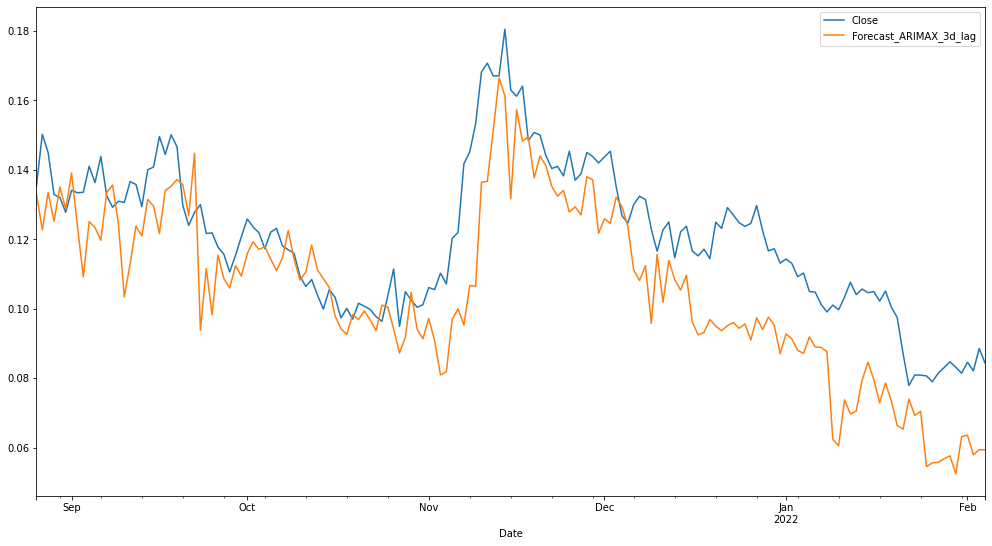

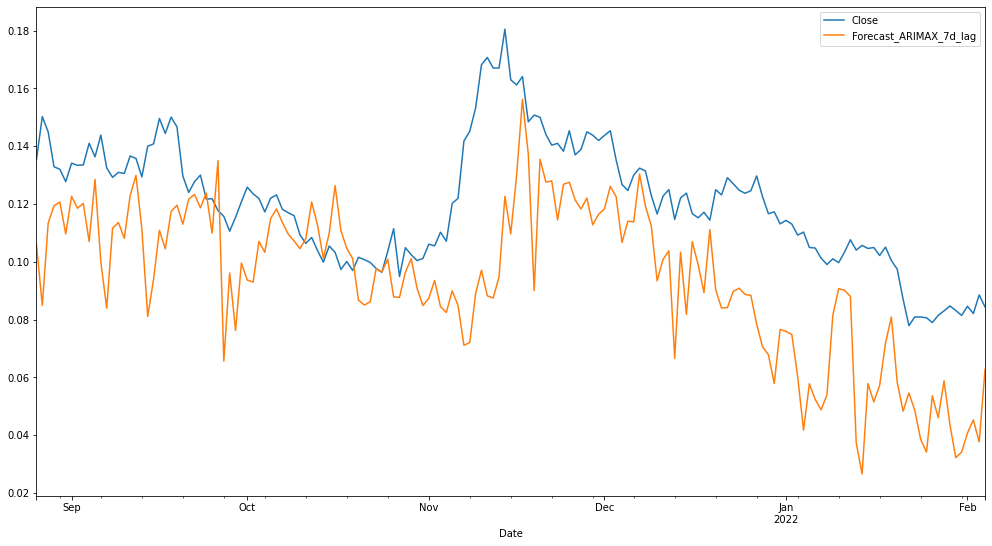

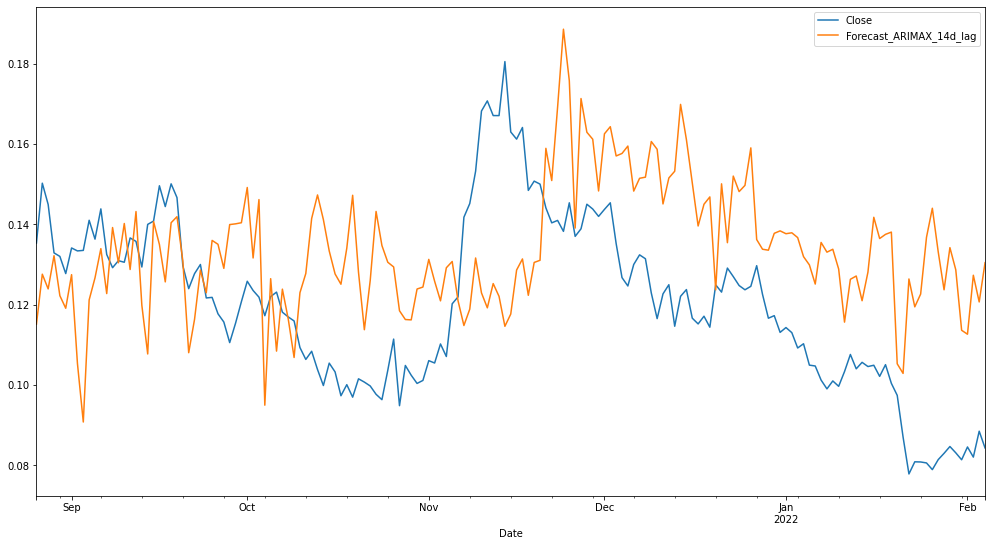

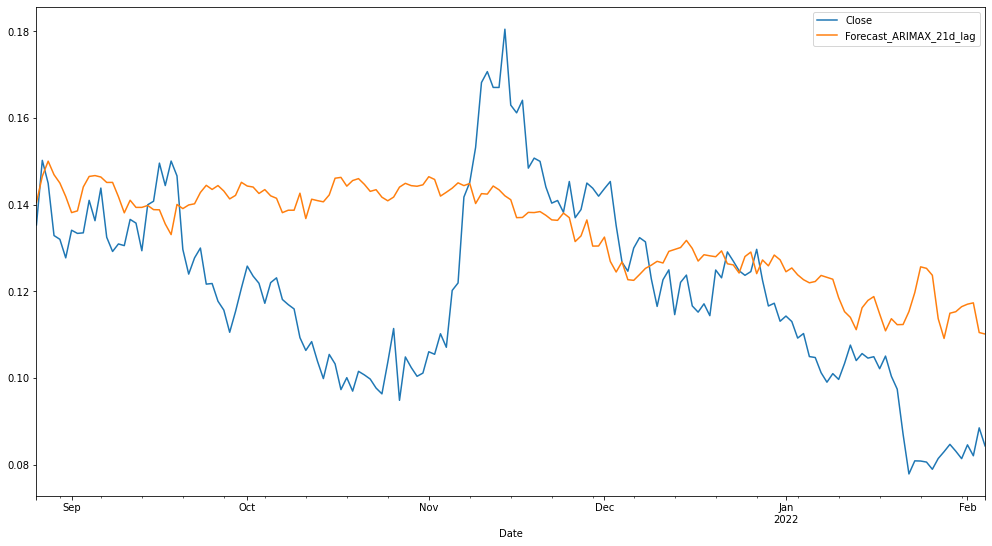

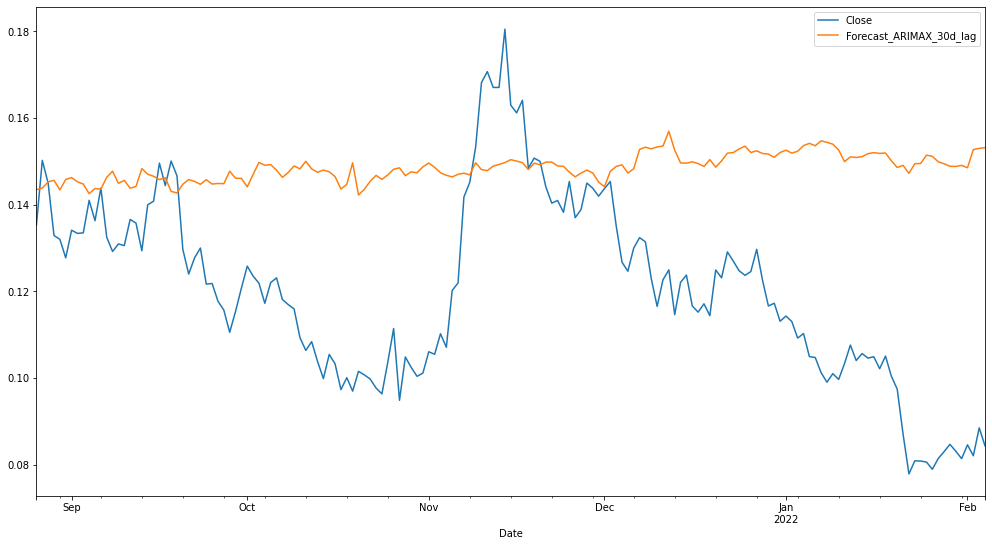

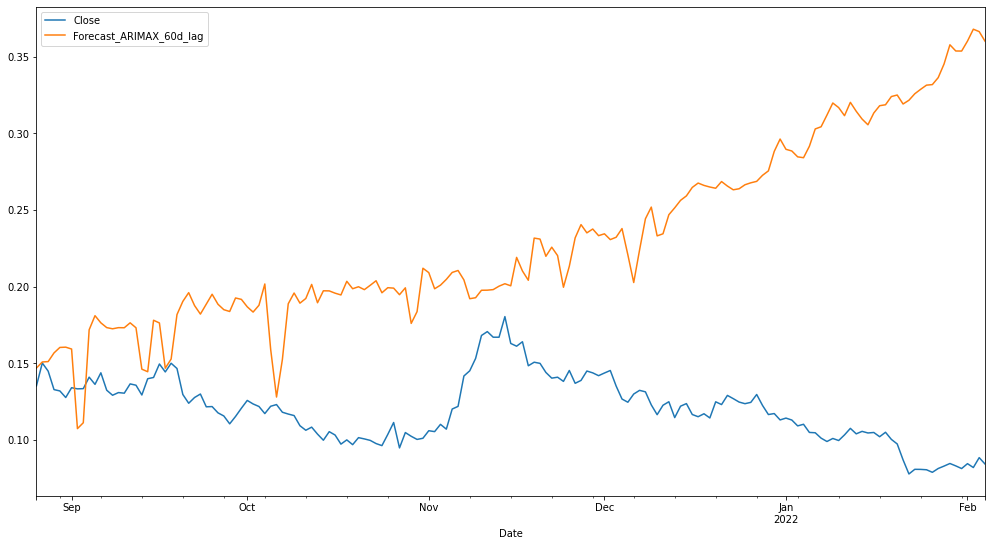

In [9]:
from python_scripts.sarima_helper import mape
from pmdarima import auto_arima

from python_scripts.sarima_helper import predict_with_windows

predict_with_windows(windows, train, test, lag_features)



In [10]:
#Povecavam trening skup na 90%
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2766.639, Time=7.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2434.933, Time=1.64 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2737.975, Time=5.85 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2551.842, Time=6.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=103.464, Time=1.99 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2768.446, Time=6.83 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2746.915, Time=6.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2736.068, Time=5.77 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2767.354, Time=6.17 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2765.722, Time=5.83 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2270.371, Time=2.58 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2763.733, Time=6.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2770.401, Time=6.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2748.648, Time=5.09 sec
 ARIMA(1,0,1)(0,0,0)[

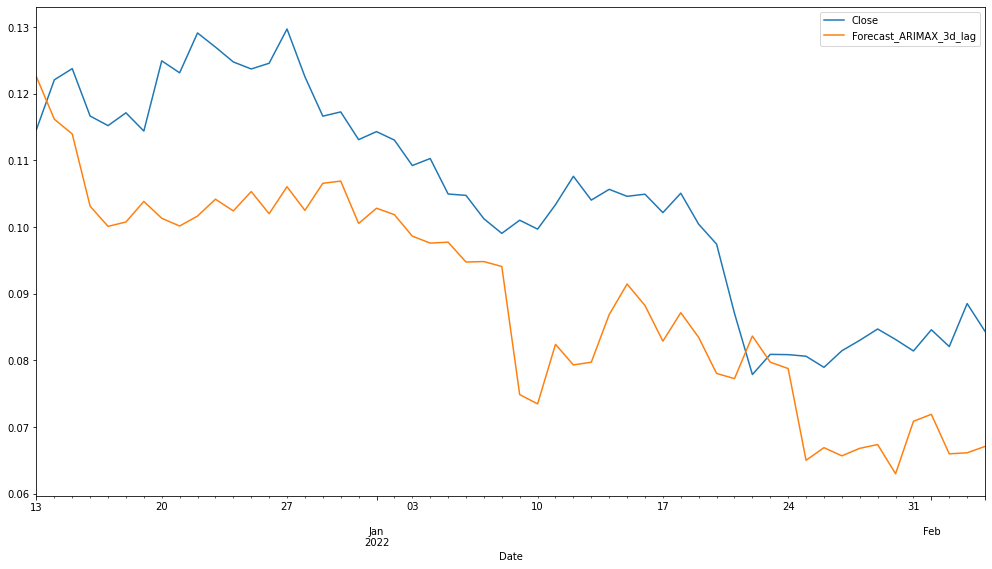

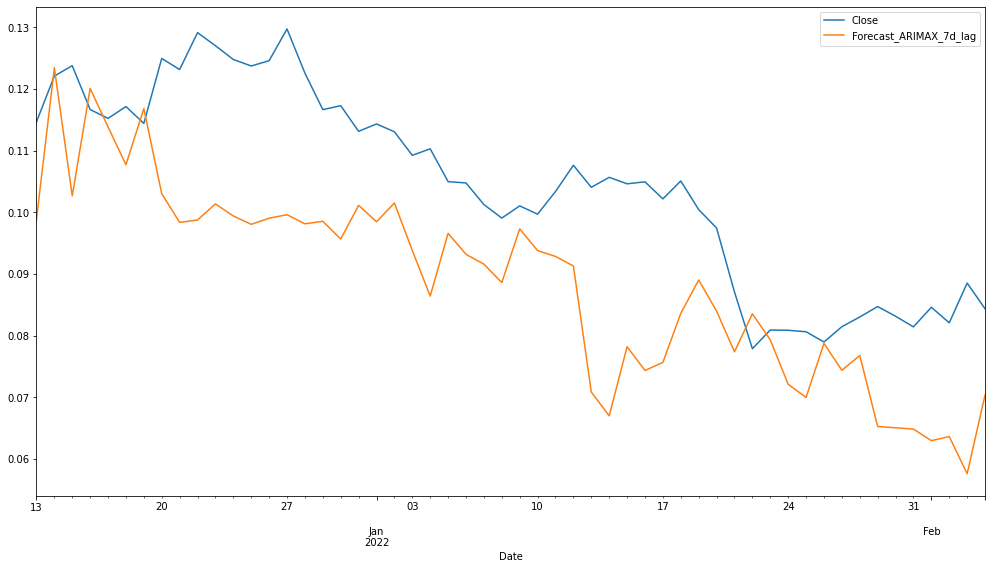

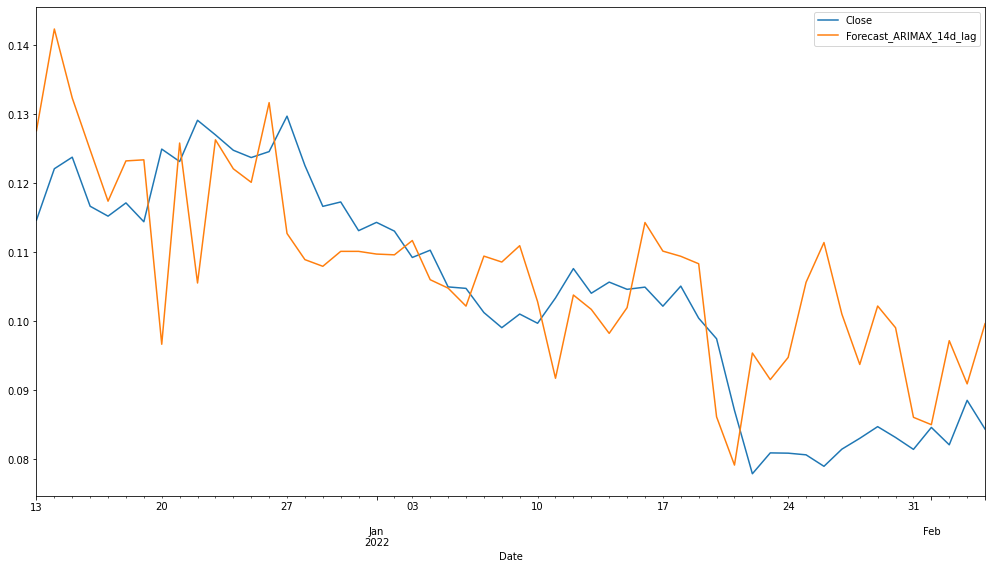

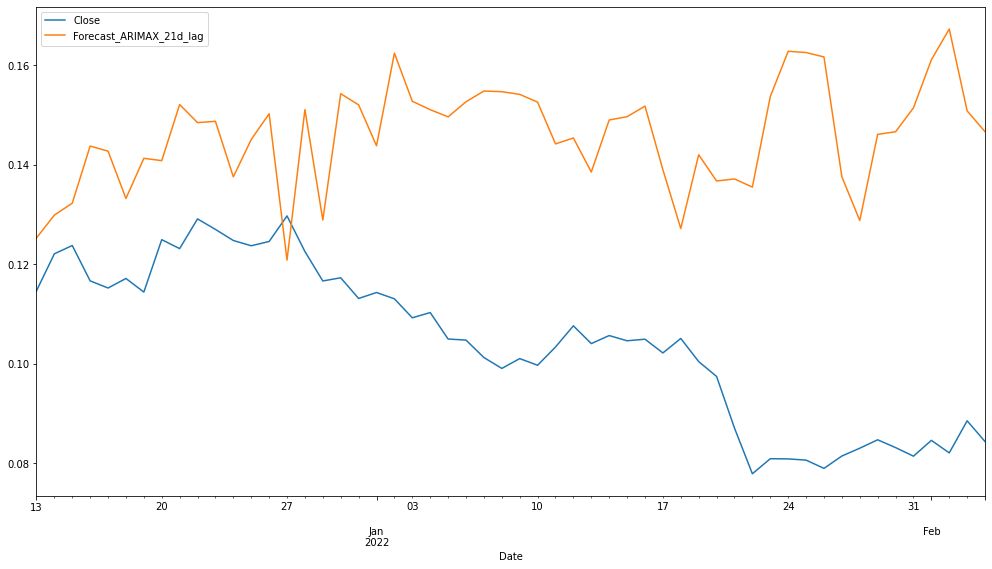

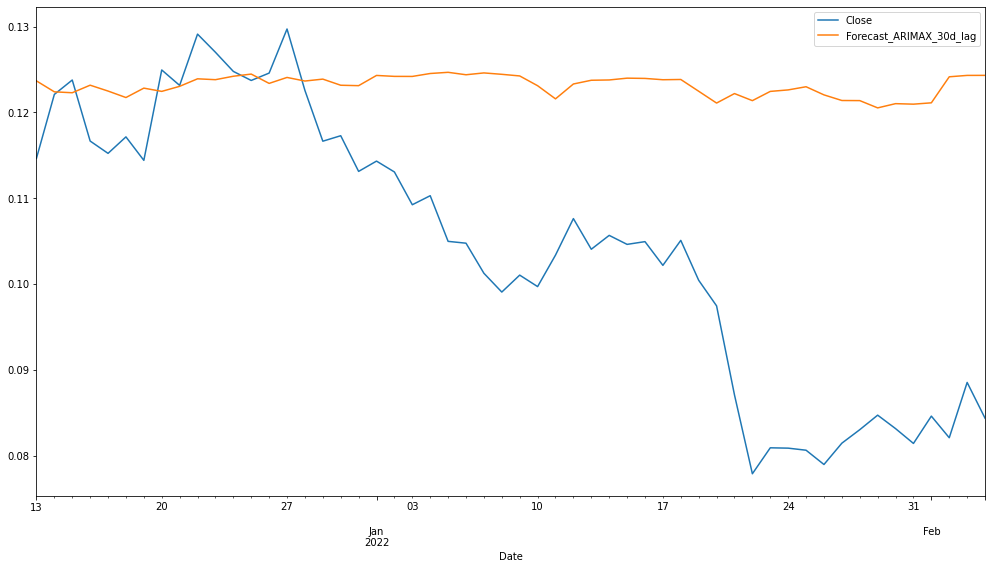

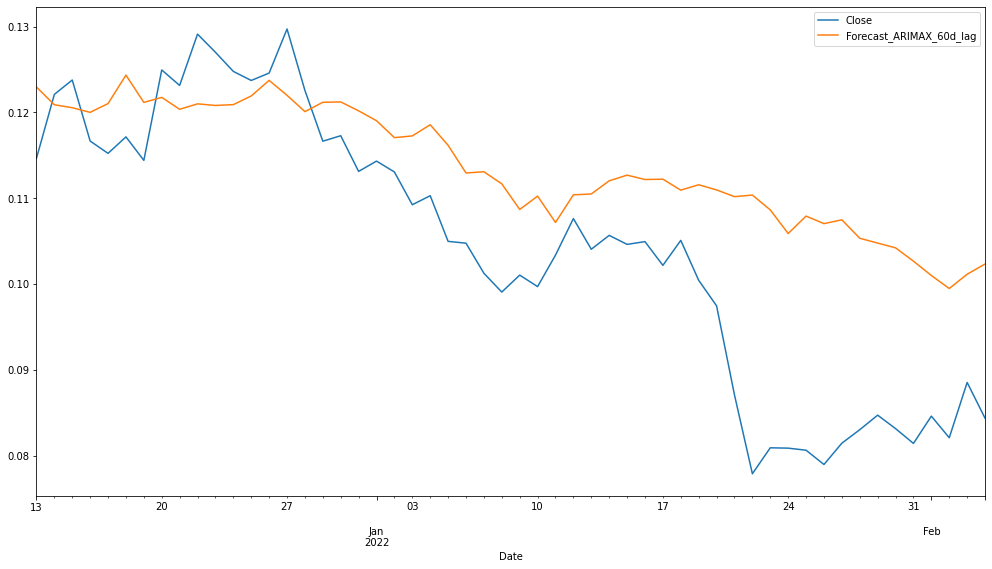

In [11]:
from python_scripts.sarima_helper import predict_with_windows

predict_with_windows(windows, train, test, lag_features)

